# Online VMP of AR(p) (no measurement noise)
State space model
\begin{align*}
    &\mathbf{x}_n = \mathbf{A}\mathbf{x}_{n-1} + \mathbf{n} \quad \mathbf{n} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}\gamma^{-1}) \\
    &y_n = \mathbf{c}^\text{T}\mathbf{x}_n
\end{align*}

or

\begin{align*}
     &p(\mathbf{x}_n\,|\,\mathbf{x}_{n-1},\mathbf{a},\gamma) = \mathcal{N}\left(\mathbf{x}_n \;\middle|\; \mathbf{A}\mathbf{x}_{n-1}, \mathbf{I}\gamma^{-1} \right)\\
    &p(y_n\,|\,\mathbf{x}_{n}) = \mathcal{N}\left(y_n \;\middle|\;\mathbf{c}^\text{T}\mathbf{x}_n, 1\text{e}-12 \right)
\end{align*}

where
\begin{align*}
    &\mathbf{x}_n = (x_n, x_{n-1}, \dots, x_{n-p+1})^\text{T} \quad \mathbf{x}_{n-1} = (x_{n-1}, x_{n-2}, \dots, x_{n-p})^\text{T} 
    \\ \\
    &\mathbf{A} = 
    \begin{bmatrix}
        a_1 & a_2 & a_3 & \dots & a_p \\
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 0
    \end{bmatrix}
    =
    \begin{bmatrix}
         \mathbf{a}^\text{T} \\
         \mathbf{I}_{p-1} \quad \mathbf{0}
    \end{bmatrix}
    \\ \\
    &\mathbf{I} = \mathbf{I}_p = 
    \begin{bmatrix}
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 1
    \end{bmatrix}
\end{align*}

┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1186
┌ Info: Precompiling QuartzImageIO [dca85d43-d64c-5e67-8c65-017450d5d020]
└ @ Base loading.jl:1186


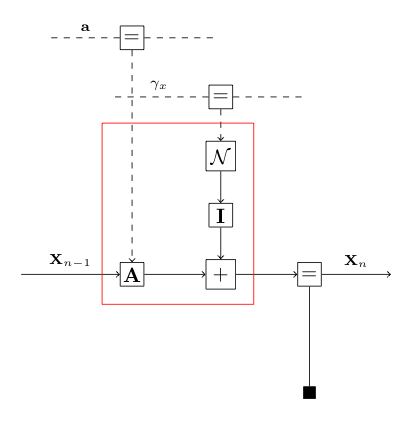

In [1]:
using Images
img = load("../ffgs/AR-online.png")

We are interested in a joint estimation of the AR coefficients $\mathbf{a}$, the precision  of the driving noise $\gamma$

In [1]:
using ProgressMeter
using Revise
using ForneyLab
include( "../AR-node/autoregression.jl")
include("../AR-node/rules_prototypes.jl")
include("../AR-node/vmp_rules.jl")
# helpers for evaluation of the model
include("../helpers/functions.jl")
# module to generate data for AR
include("../data/ARdata.jl")
import Main.ARdata: use_data, generate_data
import LinearAlgebra.I, LinearAlgebra.Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

In [3]:
ARorder = 2 # order of AR model
diagAR(dim) = Matrix{Float64}(I, dim, dim)
x = []
# AR data
a_w = 1.0; b_w = 2.0
process_noise = b_w/a_w
coefs, x = generate_data(10000, ARorder, 1, noise_variance=process_noise)
# Observations
y = [xi[1] for xi in x[ARorder:end]]

9999-element Array{Float64,1}:
 -0.6647020597550862  
 -1.621215154143229   
  1.408397160756568   
  2.325034267640446   
  1.6885110302601922  
  0.11830901734204369 
 -0.7333617037752422  
  0.5314936649058719  
  2.939236190415051   
 -2.354919543912273   
 -1.3400438527360805  
  0.8743310654159127  
 -0.4620241683741332  
  ⋮                   
 -1.0218207466409803  
 -0.6327640862021569  
  0.4869402673457847  
 -0.7934962973232804  
 -1.8289555465084149  
  0.4201563945862129  
 -0.018557993624567226
  1.4626499988469612  
 -1.8499695505339016  
  0.7808036767838359  
  0.5894462169171827  
 -0.48361699082878284 

In [4]:
g = FactorGraph()

# declare priors as random variables
@RV m_x_t_prev
@RV w_x_t_prev
@RV m_a_t
@RV w_a_t
@RV m_y_t

@RV a ~ GaussianMeanPrecision(m_a_t, w_a_t)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV w ~ Gamma(a_w, b_w)
@RV x_t = AR(a, x_t_prev, w)
c = zeros(ARorder); c[1] = 1.0
@RV y_t ~ GaussianMeanPrecision(m_y_t, huge)
DotProduct(y_t, c, x_t)

# Placeholders for prior
placeholder(m_a_t, :m_a_t, dims=(ARorder,))
placeholder(w_a_t, :w_a_t, dims=(ARorder, ARorder))

# Placeholder for data
placeholder(m_x_t_prev, :m_x_t_prev, dims=(ARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(ARorder, ARorder))
placeholder(m_y_t, :m_y_t)

ForneyLab.draw(g)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 8177802786674608871 -->
 
 8177802786674608871 
 
 Autoregression 
 autoregression_1 
 
<!-- 5833100718166212700 -->
 
 5833100718166212700 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 8177802786674608871--5833100718166212700 -->
 
 8177802786674608871--5833100718166212700 
 
 a 
 1 out 
 3 a 
 
<!-- 2243346451791193520 -->
 
 2243346451791193520 
 
 Gam 
 gamma_1 
 
<!-- 8177802786674608871--2243346451791193520 -->
 
 8177802786674608871--2243346451791193520 
 
 w 
 1 out 
 4 W 
 
<!-- 10972501648292484544 -->
 
 10972501648292484544 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 8177802786674608871--10972501648292484544 -->
 
 8177802786674608871--10972501648292484544 
 
 x_t_prev 
 1 out 
 2 x 
 
<!-- 5856247606930201594 -->
 
 5856247606930201594 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 10281579164621902347 -->
 
 10281579164621902347 
 
 clamp_3 
 
<!-- 5856247606930201594--10281579164621902347 -->
 
 5856247606930201594--10281579164621902347 
 
 clamp_3 
 1 out 
 3 w 
 
<!-- 5337509430145012823 -->
 
 5337509430145012823 
 
 placeholder_w_x_t_prev 
 
<!-- 5337509430145012823--10972501648292484544 -->
 
 5337509430145012823--10972501648292484544 
 
 w_x_t_prev 
 3 w 
 1 out 
 
<!-- 17896775557965019377 -->
 
 17896775557965019377 
 
 placeholder_m_y_t 
 
<!-- 17896775557965019377--5856247606930201594 -->
 
 17896775557965019377--5856247606930201594 
 
 m_y_t 
 2 m 
 1 out 
 
<!-- 6996289168754908899 -->
 
 6996289168754908899 
 
 clamp_4 
 
<!-- 8354137157050746066 -->
 
 8354137157050746066 
 
 clamp_1 
 
<!-- 17816443095293771979 -->
 
 17816443095293771979 
 
 placeholder_w_a_t 
 
<!-- 17816443095293771979--5833100718166212700 -->
 
 17816443095293771979--5833100718166212700 
 
 w_a_t 
 3 w 
 1 out 
 
<!-- 2243346451791193520--8354137157050746066 -->
 
 2243346451791193520--8354137157050746066 
 
 clamp_1 
 1 out 
 2 a 
 
<!-- 8749222525104871183 -->
 
 8749222525104871183 
 
 clamp_2 
 
<!-- 2243346451791193520--8749222525104871183 -->
 
 2243346451791193520--8749222525104871183 
 
 clamp_2 
 1 out 
 3 b 
 
<!-- 11746199389491504490 -->
 
 11746199389491504490 
 
 placeholder_m_a_t 
 
<!-- 11746199389491504490--5833100718166212700 -->
 
 11746199389491504490--5833100718166212700 
 
 m_a_t 
 2 m 
 1 out 
 
<!-- 7382358521957059279 -->
 
 7382358521957059279 
 
 placeholder_m_x_t_prev 
 
<!-- 7382358521957059279--10972501648292484544 -->
 
 7382358521957059279--10972501648292484544 
 
 m_x_t_prev 
 2 m 
 1 out 
 
<!-- 7991950716858294061 -->
 
 7991950716858294061 
 
 dot 
 dotproduct_1 
 
<!-- 7991950716858294061--8177802786674608871 -->
 
 7991950716858294061--8177802786674608871 
 
 x_t 
 1 out 
 3 in2 
 
<!-- 7991950716858294061--5856247606930201594 -->
 
 7991950716858294061--5856247606930201594 
 
 y_t 
 1 out 
 1 out 
 
<!-- 7991950716858294061--6996289168754908899 -->
 
 7991950716858294061--6996289168754908899 
 
 clamp_4 
 1 out 
 2 in1

In [6]:
# Specify recognition factorization
q = RecognitionFactorization(a, x_t, ids=[:A :X_t])

# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)

# Load algorithms
eval(Meta.parse(algo))

stepX_t! (generic function with 3 methods)

In [9]:
# Define values for prior statistics
m_a_0 = 0.0*rand(ARorder)
w_a_0 = (tiny*diagAR(ARorder))
m_x_prev_0 = x[ARorder - 1]
w_x_prev_0 = (0.1*diagAR(ARorder))

# Storage
m_x_prev = Vector{Vector{Float64}}(undef, length(y))
w_x_prev = Vector{Array{Float64, 2}}(undef, length(y))
m_a = Vector{Vector{Float64}}(undef, length(y))
w_a = Vector{Array{Float64, 2}}(undef, length(y))

# Inits
m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
m_a_t_min = m_a_0
w_a_t_min = w_a_0;

In [11]:
marginals = Dict()
# VMP iterations
n_its = 10
# Storage for predictions
predictions = [];

p = Progress(length(y), 1, "Observed ")
for t in 1:length(y)
    update!(p, t)
    marginals[:a] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_a_t_min, w=w_a_t_min)
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w, b=b_w)
    push!(predictions, m_a_t_min'm_x_t_prev_min)
    global m_x_t_prev_min, w_x_t_prev_min, m_a_t_min, w_a_t_min

    for i = 1:n_its
        data = Dict(:m_y_t => y[t],
                    :m_a_t => m_a_t_min,
                    :w_a_t => w_a_t_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min)
        stepX_t!(data, marginals)
        stepA!(data, marginals)
        m_a[t] = unsafeMean(marginals[:a])
        w_a[t] = unsafePrecision(marginals[:a])
        m_x_prev[t] = unsafeMean(marginals[:x_t])
        w_x_prev[t] = (huge*diagAR(ARorder))
        m_a_t_min = m_a[t]
        w_a_t_min = w_a[t]
        m_x_t_prev_min = m_x_prev[t]
        w_x_t_prev_min = w_x_prev[t]
    end
end

Observed 100%|██████████████████████████████████████████| Time: 0:00:12


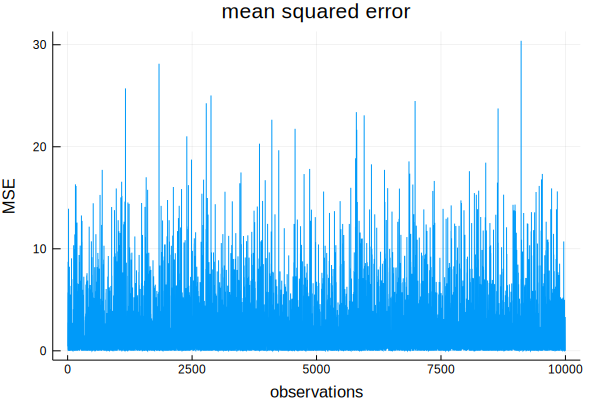

In [20]:
using Plots; theme(:default)
MSEs = [mse(predictions[i], y[i]) for i in 1:length(y)]
plot(MSEs[1:length(y)], title="mean squared error", xlabel="observations", ylabel="MSE", legend=false)

In [37]:
# Plotting predictions
anim = @animate for i in 1:100:length(predictions)
    s = plot();
    ylims!(minimum(actual) - .1, maximum(actual) + .1);
    predicted = predictions[i]
    plot!(actual, title = "unforeseen data", xlabel="time", ylabel="value", label="actual")
    plot!(predicted, label="predicted")
end
gif(anim, "../gifs/AR-online.gif", fps = 10)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/AR-online.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/AR-online.gif")

In [38]:
# Noise precision estimation
using Distributions
prior = Distributions.Gamma(a_w_0, 1/b_w_0)

anim = @animate for i in 1:100:length(a_w)
    s = plot();
    if a_w[i] <= 0 || b_w[i] <= 0
        continue
    end
    posterior = Distributions.Gamma(a_w[i], 1/b_w[i])
    plot!(pdf(prior,0:0.1:10), label="prior")
    plot!(pdf(posterior,0:0.1:10), label="posterior")
end
gif(anim, "../gifs/AR-gamma.gif", fps = 10)

┌ Warning: `pdf(d::UnivariateDistribution, X::AbstractArray)` is deprecated, use `pdf.(d, X)` instead.
│   caller = macro expansion at In[38]:11 [inlined]
└ @ Core ./In[38]:11
┌ Warning: `pdf(d::UnivariateDistribution, X::AbstractArray)` is deprecated, use `pdf.(d, X)` instead.
│   caller = macro expansion at In[38]:12 [inlined]
└ @ Core ./In[38]:12
┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/AR-gamma.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/AR-gamma.gif")

In [39]:
println("Δnoise(process, inferred)=", abs(p_noise_var - mean(marginals[:w])^-1))

Δnoise(process, inferred)=0.036120904544244437


In [40]:
# For plotting contours
using LinearAlgebra; 
 # use pyplot backend and define some defaults

len = 64

# Definition of the bivariate gaussian using a covariance matrix
𝓝(x, μ, Σ) = 1/((2 * π)^(length(μ)/2) * det(Σ)^(1/2)) * exp(-(1/2) * (x-μ)' * Σ^(-1) * (x-μ));

In [41]:
# !!! ONLY FOR AR(2)

# Plotting AR coefs
anim = @animate for i in 1:100:length(m_a)
    if !isassigned(m_a, i)
        continue
    end
    s = plot();
    plot!([m_a_0[1]],[m_a_0[2]], seriestype=:scatter, title = "AR coefs", label="prior")
    plot!([coefs[1]],[coefs[2]], seriestype=:scatter, label="true")
    plot!([m_a[i][1]],[m_a[i][2]], seriestype=:scatter, label="posterior")
    # get the maximum σ (used to construct the x and y ranges)
    σ_max = sqrt((w_a[i][1]^-1 > w_a[i][4]^-1 ) ? w_a[i][1]^-1 : w_a[i][4]^-1)

    rx = range(m_a[i][1]-3*σ_max, m_a[i][1]+3*σ_max, length=len)
    ry = range(m_a[i][2]-3*σ_max, m_a[i][2]+3*σ_max, length=len)
    contour!(rx, ry, (x1, x2) -> 𝓝([x1 ; x2], m_a[i], w_a[i]^-1), xlabel="a1", ylabel="a2")
end
gif(anim, "../gifs/AR-coefs.gif", fps = 10)

DimensionMismatch: DimensionMismatch("dimensions must match")

In [21]:
coefs

2-element Array{Float64,1}:
 -0.015141570153819728
 -0.3252128461218913  

In [23]:
mean(marginals[:w])^-1

2.0

In [22]:
mean(marginals[:a])

2-element Array{Float64,1}:
 -0.02466757846296958
 -0.33339823321547457